## Self-avoiding walk (SAW)

We simulate a self-avoiding walk (SAW) on a square lattice. Each walk represents a possible conformation of a polymer composed of $N$ monomers. We use a simple Monte Carlo algorithm to sample the possible conformations of the polymer.

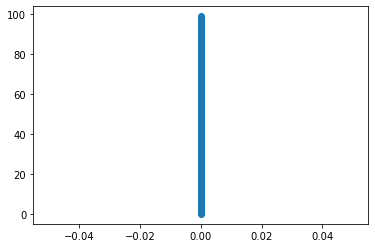

In [3]:
import numpy
import matplotlib.pyplot as plt 

# Model parameters
N = 100
L = 1000
matrix = numpy.zeros((L+1, L+1), dtype=int)

# Setup initial configuration as a long linear chain wrapped around the boundaries
positions = []
for x in range(L):
    for y in range(L):
        if x % 2 != 0:
            y = L - y
        positions.append([x, y])
        matrix[x, y] = 1
        if len(positions) >= N:
            break
    if len(positions) >= N:
        break

plt.plot([r[0] for r in positions], [r[1] for r in positions], '-o')

Now we update the walk using a simple Monte Carlo algorithm. At every step, we try to remove the monomer from the tail (head) and attach it to the head (tail), accepting new conformations if satify the self-avoidance constraint but retaining the old ones if they don't.

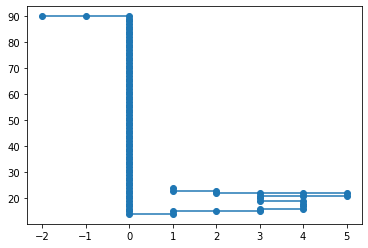

In [4]:
# Pick up first monomer
import random

steps = 1000
for step in range(steps):
    # Either take the first particle and add it to the tail (drop=0, insert=-1)
    # or the opposite (drop=-1, insert=0)
    drop, insert = random.choice([[0, -1], [-1, 0]])

    # Attempt to put the particle at position `pos`
    delta = random.choice([[1, 0], [-1, 0], [0, 1], [0, -1]])
    pos = positions[insert][:] + numpy.array(delta)
    
    # If the new site is empty, add the particle
    if matrix[pos[0], pos[1]] == 0:
        new = positions.pop(drop)
        matrix[new[0], new[1]] = 0
        matrix[pos[0], pos[1]] = 1
        new[:] = pos

        # Either add to the head or the tail
        if insert == 0:
            positions.insert(0, new)
        else:
            positions.append(new)
       
plt.plot([r[0] for r in positions], [r[1] for r in positions], '-o')

**Exercise 1**: *Equilibration*

How many steps are required to "equilibrate" the SAW? To get a feeling, execute the blocks above several times until *by visual inspection* the SAW looses memory of its initial shape. Keep track of the total number of equilibration steps for $N=10, 100, 1000$. What do you observe?

1. Per "equilibrare" il SAW sono necessari un numero $\sim N^{2}$ di equilibration steps, quindi il numero necessario cresce con N

**Exercice 2**: *Flory exponent*

Compute the root-mean-square end-to-end vector $R\equiv {\langle |\vec{R}|^2\rangle}^{1/2}$ for several $N$ in the interval $[10, 500]$ and estimate the Flory exponent $\nu$ defined by the relation
$$R \sim N^\nu$$
Compare your numerical results to the Flory argument for a SAW in $d=2$ spatial dimensions, 

*Hint 1*: do not forget to ignore the conformations sampled during the equilibration phase!

*Hint 2*: you may want to encapsulate the blocks above into separate functions that initialize and update the SAW respectively. 

*To go beyond*: Adapt the code to generate SAWs in $d=3$. Find the Flory exponent and compare it to the Flory argument ($\nu=3/5$) and to the result of renormalization group theory ($\nu=0.588$). In order to actually favor one theoretical prediction over the other, high quality data are needed and it is recommended to perform the simulations in a more efficient language such as C, Fortran or Julia. If you want to keep using python you may want to try `f2py` or `f2py-jit` (to integrate Fortran 90 in python) or `numba` (to compile python just-in-time!) or related tools.

In [5]:
def initialize(N, L):
    matrix = numpy.zeros((L+1, L+1), dtype=int)

    # Setup initial configuration as a long linear chain wrapped around the boundaries
    positions = []
    for x in range(L):
        for y in range(L):
            if x % 2 != 0:
                y = L - y
            positions.append([x, y])
            matrix[x, y] = 1
            if len(positions) >= N:
                break
        if len(positions) >= N:
            break
    return positions, matrix

In [6]:
def update(steps, positions, matrix):
    for step in range(steps):
        # Either take the first particle and add it to the tail (drop=0, insert=-1)
        # or the opposite (drop=-1, insert=0)
        drop, insert = random.choice([[0, -1], [-1, 0]])

        # Attempt to put the particle at position `pos`
        delta = random.choice([[1, 0], [-1, 0], [0, 1], [0, -1]])
        pos = positions[insert][:] + numpy.array(delta)

        # If the new site is empty, add the particle
        if matrix[pos[0], pos[1]] == 0:
            new = positions.pop(drop)
            matrix[new[0], new[1]] = 0
            matrix[pos[0], pos[1]] = 1
            new[:] = pos

            # Either add to the head or the tail
            if insert == 0:
                positions.insert(0, new)
            else:
                positions.append(new)
    return positions, matrix

17.73302004735798 0.6243913525215592


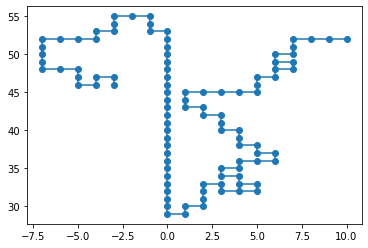

In [7]:
# Model parameters
N = 100
L = 1000
positions, matrix = initialize(N, L)
positions, matrix = update(N**2, positions, matrix)
plt.plot([r[0] for r in positions], [r[1] for r in positions], '-o')

# Compute root mean square end to end vector and Flory exponent
data_steps = 1000
R2 = 0
for i in range(data_steps):
    positions, matrix = update(1, positions, matrix)
    R2 += (positions[0][0] - positions[-1][0])**2 + (positions[0][1] - positions[-1][1])**2
    
mean_square_R = numpy.sqrt(R2/data_steps)
flory_exp = numpy.log(mean_square_R) / numpy.log(N)
print(mean_square_R, flory_exp)

In [8]:
# Compute root mean square end to end vector and Flory exponent
# with a loop over N to improve statistics

flory_exp = 0
N_range = numpy.linspace(10, 500, 50)
for N in N_range:
    positions, matrix = initialize(N, L)
    positions, matrix = update(int(N**2), positions, matrix)

    data_steps = 1000
    mean_square_R = 0
    R2 = 0
    for i in range(data_steps):
        positions, matrix = update(1, positions, matrix)
        R2 += (positions[0][0] - positions[-1][0])**2 + (positions[0][1] - positions[-1][1])**2
    mean_square_R += numpy.sqrt(R2/data_steps)
    
    flory_exp += numpy.log(mean_square_R) / numpy.log(N)
    
flory_exp = flory_exp / len(N_range)
print("La stima dell'esponente di Flory risulta: nu =", flory_exp)
print("\nConsistente con la previsione basata sull'argomento di Flory secondo cui in 2 dimensioni nu = 0.75")

La stima dell'esponente di Flory risulta: nu = 0.728638076888503

Consistente con la previsione basata sull'argomento di Flory secondo cui in 2 dimensioni nu = 0.75


**Exercice 3**: *fractal dimension* $D$
    
Measure the fractal dimension of a SAW in $d=2$ dimensions using the relation
$$
\langle N(r)\rangle \sim r^D
$$
where $N(r)$ is the number of particles in a circle of radius centered on the polymer center of mass. Compare to the theoretical expectation based on the Flory argument.

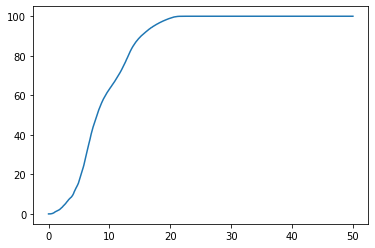

In [9]:
# Model parameters
N = 100
L = 10000
positions, matrix = initialize(N, L)
positions, matrix = update(N**2, positions, matrix)
#plt.plot([r[0] for r in positions], [r[1] for r in positions], '-o')

data_steps = 1000
rdata = numpy.linspace(0, int(N/2), 1000)
N_r = numpy.zeros(1000)
for i in range(data_steps):
    positions, matrix = update(1, positions, matrix)
    # Compute center of mass
    CM_x = 0
    CM_y = 0
    for position in positions:
        CM_x += position[0]
        CM_y += position[1]
    CM_x = CM_x / len(positions)
    CM_y = CM_y / len(positions)
    #plt.plot([r[0] for r in positions], [r[1] for r in positions], '-o')
    #plt.plot (CM_x, CM_y, '-o')
    
    # Compute <N(r)>
    for position in positions:
        cm_distance = numpy.sqrt( (position[0] - CM_x)**2 + (position[1] - CM_y)**2)
        index = 0
        for r in rdata:
            if cm_distance < r:
                N_r[index] += 1
            index += 1
    #N_r = N_r / len(positions)
N_r = N_r / data_steps
    
plt.plot(rdata, N_r)

1.693
fractal dimension: 2.1343967064237117


(0.0, 100.0)

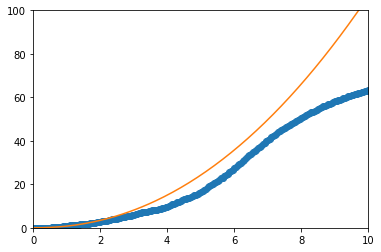

In [25]:
from scipy.optimize import curve_fit

def func(x, a, b):
    return a * x**b

plt.plot(rdata, N_r, 'o', label='data')
fit_max = int(1000/N*3)
print(N_r[fit_max])
popt, pcov = curve_fit(func, rdata[:fit_max], N_r[:fit_max])
print("fractal dimension:", popt[1])

# Note the *popt syntax unpacks the array into individual variables
plt.plot(rdata, func(rdata, *popt), '-')
plt.xlim([0,10])
plt.ylim([0,N])